# Area of Maximum Variability

## Setup

In [1]:
# Import statements

import xarray as xr
import cartopy.crs as ccrs
from typing import List
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import numpy as np

plt.style.use("dark_background")


In [2]:
# Function definitions
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})


In [3]:
# Load in 20-23Z initializations

wofs_all = [get_wofs_all(i) for i in [20, 21, 22, 23]]


In [5]:
# Define variables and parameters

lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection

proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension

init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)


## Find area

In [6]:
# Extract 5-min rain field

rain = get_field(wofs_all, "rain", "2021-09-01 23:00:00", "2021-09-02 02:00:00", init)

# Get standard deviation of 01–02 UTC accumulated rainfall

std = (
    rain.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .std(dim=("ne", "init"))
)


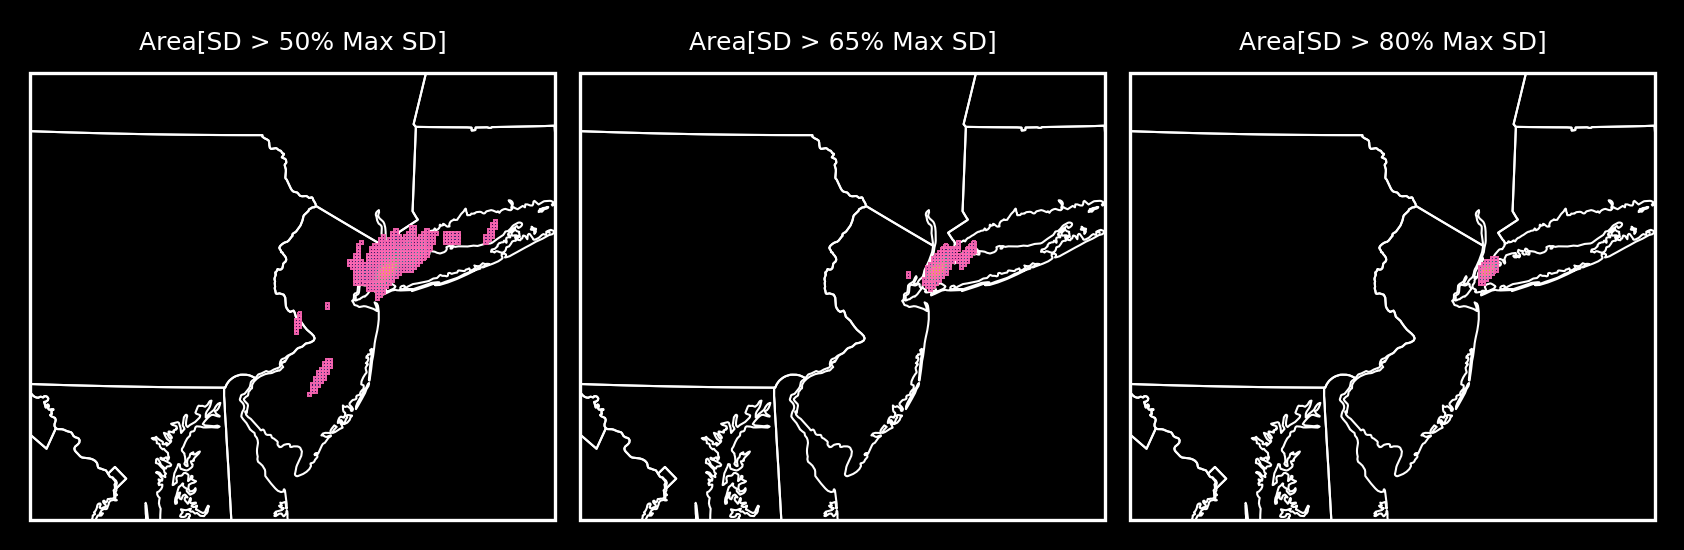

In [30]:
# Plot a few different areas
thresholds = [0.5, 0.65, 0.8]
cutoffs = [std.max() * th for th in thresholds]
titles = ["Area[SD > 50% Max SD]", "Area[SD > 65% Max SD]", "Area[SD > 80% Max SD]"]

# Make figure
fig, axes = plt.subplots(
    1,
    3,
    figsize=(5.5, 2),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Iterate through each axis
for i, ax in enumerate(axes.flat): # type: ignore
    masked_std = np.ma.masked_less_equal(std, cutoffs[i])  # Mask values that are less than or equal to the cutoff
    cp = ax.pcolor(lon, lat, masked_std, color=["hotpink"], transform=ccrs.PlateCarree(), zorder=2, alpha=0.9,) #levels=[0,100])

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=1)

    ax.set_extent([-78,-72,38.5,42.5])

    ax.set_title(titles[i],fontsize=6)

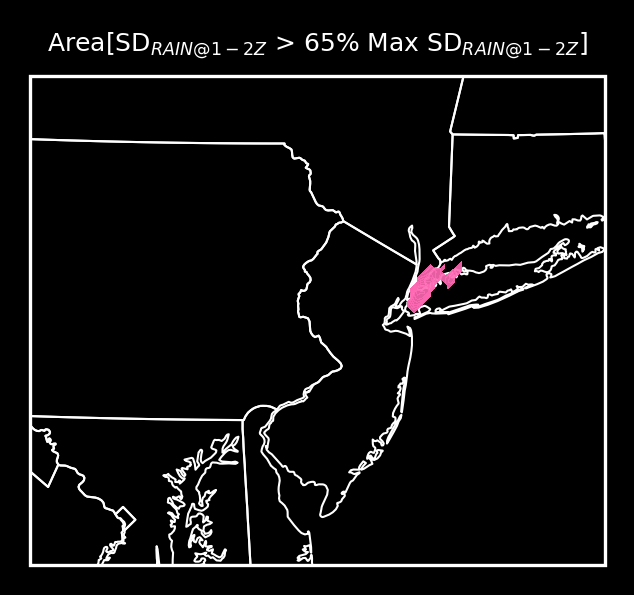

In [10]:
# Plot a map of the 65% percentile
threshold = 0.65
cutoff = std.max() * threshold
title = "Area[SD$_{RAIN@1-2Z}$ > 65% Max SD$_{RAIN@1-2Z}$]"

# Make figure
fig, ax = plt.subplots(
    1,
    1,
    figsize=(2, 2),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

masked_std = np.ma.masked_less_equal(std,cutoff) # Mask values less than or equal to the cutoff
cf = ax.contourf(lon,lat,masked_std,colors=["hotpink"], transform=ccrs.PlateCarree(), zorder=2, alpha=0.9)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white",zorder=1)
ax.set_extent([-78,-72,38.5,42.5])

ax.set_title(title,fontsize=6)

plt.show()

In [25]:
# Double-check that Central Park is still included

# Set desired latitude and longitude (Central Park)
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Use 65% of SD

(std >= (std.max() * 0.65))[lat_ind,lon_ind].load()

<xarray.DataArray 'rain' ()> Size: 1B
array(True)